## Hierarchical Context Dynamics

We would like in a 2 layer network designed for sequence learning (e.g. an RSM-like model), for the higher layer to learn a context that summarizes transitions in the layer below across multiple time steps. This is sometimes known as chunking, pattern completion, ... 

We explore a mechanism that should enable such context learning in a network trained with backpropagation. We use a toy problem in which an agent randomly moves through an environment of digits. The landscape is chosen such that nearby digits are predictive of other nearby digits forming "regions" that an agent may learn to develop as a context to improve sequence predictions related to movement in these areas.



#### NEXT

- Work on decay, and some threshold for predictions
- Sensor noise
- **Degeneracy is a big part of the reason why L2 is invariant across contexts. Try quick decay unless... permanence.**
- Keep L2 at a minimum level to make it easier to recruit?
- Concat FF and FB and learn transformation to additive delta?

#### TODO

- Missing: confirmed predictions should weigh *ANY* prediction + confirmation above all inputs without predictions
- kWinners preds separate from FF? [tried]
- Add a confusion matrix on each digit representation at L1/L2?
- Stochastic / sparse backprop?
- Subtractive decay

#### Problems

- We are converging on shared L2 cells for all contexts
- Then BP doesn't know whether to reduce current context which is producing error, or change predictions of current context
- How to differentiate L2 representations?
- Problem with K-Winners, always equally confident?

### Prior

- Sparsity and re-tying are not playing together well. Fix! [maybe done]


### Model

[Image showing predictive temporal dynamics and recruitment of context]

#### Dynamics 

- Bidirectional connections
- Downward flowing feedback
- Upward flowing inputs
- Predicted + Verified >>> Predicted | Verified (non-linearity)
- Hysteresis of verified contexts
    
#### Proposed Structure

Each layer has a FF layer and a feedback layer connected to prior time step at layer above. Layers are initialized with sparse bidirectionally (biased) weights, similar to "tying". 

$W^A$: FF weights

$W^{FB}$: Feedback weights

Nonlinearity...

Hysteresis, need some sort of decay function that keeps high activations around for longer. Maybe just a thresholded activation allowed > 1? 




## Toy Problem & Model Code

### Expectations

We expect to see a context learned within a couple time steps of a new "region" being entered, and deactivated upon exit. During the period this context is active, it should produce the proper predictions aligned with the true distribution of this region.

We expect the context to be robust to noise (unpredicted labels), but adapt quickly when true region changes occur.

In [164]:
import torch
import copy
import numpy as np
import hiddenlayer as hl
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from nupic.torch.modules.sparse_weights import SparseWeights
from nupic.torch.modules.k_winners import KWinners
from random import choice

ENCODER_W = 4

class Environment():
    def __init__(self, landscape="simple"):
        if landscape == "simple":
            self.data = torch.tensor([
                [0, 0, 0, 0, 3, 4, 3],
                [0, 1, 0, 1, 2, 4, 4],
                [0, 0, 1, 0, 3, 4, 2],            
                [0, 1, 0, 1, 4, 4, 3], 
                [1, 0, 1, 1, 4, 3, 4],             
                [1, 0, 1, 0, 4, 2, 3],                         
                [0, 0, 1, 1, 4, 2, 3],                         
            ])
        elif landscape == "partitioned":
            self.data = torch.tensor([
                [5, 5, 5, -1, 6, 6, 6],
                [5, 5, 5, -1, 6, 6, 6],
                [4, 4, 4, -1, 1, 1, 1],            
                [4, 4, 4, -1, 1, 1, 1], 
                [3, 3, 3, -1, 1, 1, 1],             
                [3, 3, 3,  2, 0, 0, 0],                         
                [3, 3, 3,  2, 0, 0, 0],                         
            ])
        elif landscape == "partitioned_sm":
            self.data = torch.tensor([
                [0, 0, -1, 0, 0, 0],
                [0, 0, -1, 0, 0, 0],
                [0, 0, -1, 0, 3, 0],            
                [1, 1, -1, 0, 3, 3],             
                [1, 0, -1, 3, 0, 0],                         
                [0, 1,  2, 0, 0, 3],                         
            ])
        elif landscape == "split":
            self.data = torch.zeros(10, 10).long()
            self.data[:, 5:] = 1
        self.n_digits = len(self.data.unique())
        self.w, self.h = self.data.size()
    
    def digit_at(self, loc):
        return self.data[loc[0], loc[1]]
    
    def sense(self, locs, noise=0.1):
        w = ENCODER_W
        encoded = noise * torch.rand((locs.size(0), self.n_digits * w)).float()
        for i, loc in enumerate(locs):
            digit = self.digit_at(loc)
            # Encode as one-hot
            encoded[i, w*digit:w*(digit+1)] = 1.0
        return encoded
        

class Agents():
    def __init__(self, net, env=None, lr=0.001, input_transitions=False):
        self.movement = 'random'
        self.time = 0
        self.env = env
        self.bsz = net.bsz
        self.input_transitions = input_transitions
        x = torch.LongTensor(self.bsz).random_(env.w-1)
        y = torch.LongTensor(self.bsz).random_(env.h-1)  
        self.location = torch.stack((x, y), dim=1)  # bsz x 2
        self.net = net
        self.optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=.0001)
        #self.optimizer = torch.optim.Adam(net.parameters(), lr=.001)
        self.criterion = nn.MSELoss()

        # Staggered
        self.last_out = None
        self.last_hidden = self.net.init_hidden()
    
        self.last_x = None

    def move(self, to=None):
        """
        Move each agent to new location
        """
        if to is not None:
            new_loc = to.repeat(self.bsz, 1)
        else:
            if self.movement == 'random':
                deltas = torch.zeros(self.bsz, 2).long()
                for i in range(self.bsz):
                    valid = False
                    while not valid:
                        delta = torch.tensor(choice([(1, 0), (0, -1), (-1, 0), (0, 1)]), dtype=torch.long)
                        agent_new_loc = self.location[i] + delta
                        x, y = agent_new_loc[0].item(), agent_new_loc[1].item()
                        oob_x = x < 0 or x > self.env.w - 1
                        oob_y = y < 0 or y > self.env.h - 1
                        if not oob_x and not oob_y:
                            digit = self.env.digit_at(agent_new_loc)
                            in_barrier = digit == -1  # barrier
                            valid = not in_barrier
                    deltas[i, :] = delta
            new_loc = self.location + deltas
        new_loc[:, 0] = torch.clamp(new_loc[:, 0], 0, self.env.w-1)
        new_loc[:, 1] = torch.clamp(new_loc[:, 1], 0, self.env.h-1)                
        self.location = new_loc
        return self.env.sense(self.location)
    
    def step(self, x, learning=True, plot_state=False):
        predictions = None
        if learning:
            self.net.train()
        else:
            self.net.eval()
        
        # Forward
        hidden = self.last_hidden
        # hidden[0][0].detach_()  # Detach L1 from t-1 (staggered graph)
        
        self.optimizer.zero_grad()
        
        loss_val = None
        if self.last_out and learning:
            last_pred = self.last_out[0]
            # Predicted (from L1) with actual image (or actual transition)
            if self.input_transitions:
                loss_input = x - self.last_x if self.last_x is not None else x
            else:
                loss_input = x 
            loss = self.criterion(last_pred, loss_input)
            
            # For charts
            for layer in self.net.children():
                layer.z_a.retain_grad()
                layer.z_fb.retain_grad()
                layer.sigma.retain_grad()

            loss.backward()
            loss_val = loss.item()
            self.optimizer.step()            
            if plot_state:
                plot_net_state(self.net, last_pred, x, hidden)

        out, hidden = self.net(x, hidden)
        
        self.last_out = out
        self.last_hidden = hidden
        self.last_x = x
        self.time +=1 
        
        # Return prediction from first layer
        return loss_val, out[0] 
        
class Net(nn.Module):
    def __init__(self, cells=[6**2, 6**2], d_in=10, 
                 bsz=1, bs=[1.0, 1.0], n_layers=2, 
                 bidirectional=True,
                 bidirectional_tied=False,
                 input_transitions=False,
                 sparsity=0.3, debug=False):
        super(Net, self).__init__()        
        self.debug = debug        
        self.n_layers = n_layers
        self.bidirectional = bidirectional
        self.bidirectional_tied = bidirectional_tied
        self.bsz = bsz if not self.debug else 1
        self.d_in = d_in
        self.cells = cells
        self.input_transitions = input_transitions
        next_d_in = d_in
        self.last_x = torch.zeros(d_in)
        l = 0
        for l_cells, l_bs in zip(self.cells, bs):
            top = l == self.n_layers-1
            eps = 0.3 if top else 0
            layer = Layer(cells=l_cells, 
                          d_in=next_d_in, 
                          d_fb=self.cells[l+1] if not top else 0,
                          layer_id=l, 
                          sparsity=sparsity, 
                          bsz=self.bsz,
                          bs=l_bs,
                          eps=eps,
                          debug=debug)
            self.add_module("L%d" % (l+1), layer)
            next_d_in = l_cells
            l += 1
        self.sparsity_mask = torch.zeros(cells[0], cells[1])
        self.sparsity_mask[torch.rand(cells[0], cells[1]) < sparsity] = 1
                  
    def _retie_weights(self, strategy="mean"):
        """
        Re-enforce bidirectionality after backprop
        """
        if self.bidirectional:
            if self.bidirectional_tied:
                weight1 = self.L1.linear_fb.weight
                weight2 = self.L2.linear_ff.weight.t()    
                if strategy == "mean":
                    new_weight = (weight1 + weight2) / 2.0
                elif strategy == "stochastic":
                    new_weight = choice([weight1, weight2])
                new_weight *= self.sparsity_mask
                self.L1.linear_fb.weight.data.copy_(new_weight.data)
                self.L2.linear_ff.weight.data.copy_(new_weight.data.t())
            else:
                self.L1.linear_fb.weight.data *= self.sparsity_mask
                self.L2.linear_ff.weight.data *= self.sparsity_mask.t()
                
    
    def init_hidden(self):
        x_bs = []
        for l_cells in self.cells:
            x_bs.append(torch.zeros((self.bsz, l_cells), dtype=torch.float32))
        return (
            x_bs,
        )
    
    def staggered_forward(self, x, hidden):
        x_bs, = hidden
        new_x_b = []
        output_by_layer = []
        
        hidden_in = (None, )
        out_l2, hidden_l2 = self.L2(x_bs[0].detach(), hidden_in)

        x_fb = hidden_l2[0]
        hidden_in = (x_fb, )
        out_l1, hidden_l1 = self.L1(x, hidden_in)
        
        output_by_layer = [out_l1, out_l2]
        new_x_b = [hidden_l1[0], hidden_l2[0]]
        hidden = (new_x_b, )
        return (output_by_layer, hidden)
    
    def forward(self, x, hidden):
        return self.staggered_forward(x, hidden)
    
class Layer(nn.Module):
    def __init__(self, cells=6**2, 
                 d_in=10, 
                 d_fb=10, 
                 sparsity=0.3, 
                 fb_sparsity=0.1, 
                 k_winner_pct=0.3,
                 layer_id=0, 
                 bs=1.0, 
                 bsz=1,
                 eps=0.0,
                 debug=False):
        super(Layer, self).__init__()
        self.debug = debug
        self.bsz = bsz
        self.cells = cells
        self.d_in = d_in
        self.d_fb = d_fb
        self.eps = eps
        self.layer_id = layer_id
        self.linear_ff = nn.Linear(d_in, cells)
#         if sparsity < 1:
#             self.linear_ff = SparseWeights(self.linear_ff, sparsity)
        self.kwinners_ff = KWinners(cells, k_winner_pct, boost_strength=bs)
        self.kwinners = KWinners(cells, k_winner_pct, boost_strength=bs)        
        bottom = self.layer_id == 0
        self.linear_d = nn.Linear(self.cells, d_in)
        if bottom:
            # Don't learn on bottom FF layer
#             self.linear_ff.weight.requires_grad_(False)
#             self.linear_ff.bias.requires_grad_(False)
            self.linear_fb = nn.Linear(self.d_fb, cells)
#             if sparsity < 1:
#                 self.linear_fb = SparseWeights(self.linear_fb, fb_sparsity)
            self.kwinners_fb = KWinners(cells, k_winner_pct, boost_strength=bs)     
        self.z_a = torch.zeros(self.bsz, cells, requires_grad=True)
        self.z_fb = torch.zeros(self.bsz, cells, requires_grad=True)
        self.sigma = torch.zeros(self.bsz, cells, requires_grad=True)
        print("Created %s" % self)
    
    def __str__(self):
        return "<Layer%d cells=%d d_in=%d />" % (self.layer_id, self.cells, self.d_in)
        
    def decode(self, sigma):
        """
        Decode through tied weights
        """
#         out = F.linear(sigma, self.linear_ff.weight.t())
        out = self.linear_d(sigma)
        return out
    
    def forward(self, x, hidden):
        x_fb, = hidden
        
#         self.z_a = self.kwinners_ff(self.linear_ff(x))
        self.z_a = self.linear_ff(x)
        
        # sigma = self.sigma.detach()
        
#         STRAT = "tanh"
#         if self.eps:
#             if STRAT == "thresh":
#                 inactive_mask = (sigma < 0.5).float()
#                 sigma = sigma * self.eps * inactive_mask
#             elif STRAT == "tanh":
#                 decay = torch.tanh(sigma)
#                 sigma = sigma * decay
            
        if x_fb is not None:
#             self.z_fb = self.kwinners_fb(self.linear_fb(x_fb))
            self.z_fb = self.linear_fb(x_fb)
        else:
            self.z_fb = torch.zeros_like(self.z_a)
        
        y = F.tanh(self.z_a + self.z_fb)
        self.sigma = self.sigma.detach() + y
        # Decay
#         y = self.z_a + self.z_fb + 30*self.z_a * self.z_fb
#         y = self.z_a + self.z_fb + 10*self.z_a * self.z_fb

        #sigma = sigma - sigma.min() + 1
#         self.sigma = self.kwinners(self.sigma)

        # Normalize
        self.sigma = torch.sigmoid(self.sigma)
#         alpha = self.sigma.sum()
#         self.sigma = self.sigma / (alpha + 1e-9)

        out = self.decode(self.sigma)

        hidden = (self.sigma, )
        return (out, hidden)

Created <Layer0 cells=49 d_in=20 />
Created <Layer1 cells=9 d_in=49 />


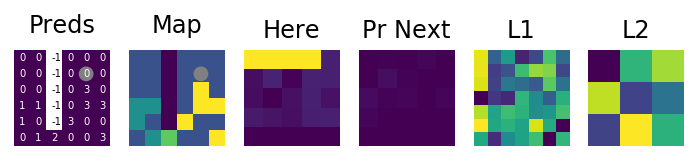

[tensor(0.0023), tensor(0.0050), tensor(0.0004), tensor(7.1049e-05), 0]
400/8000: Avg L1 fb weight: 0.15797, avg L2 ff weight: 0.07043, L1 max: 0.849, L2 max: 0.760, loss - 0.16607


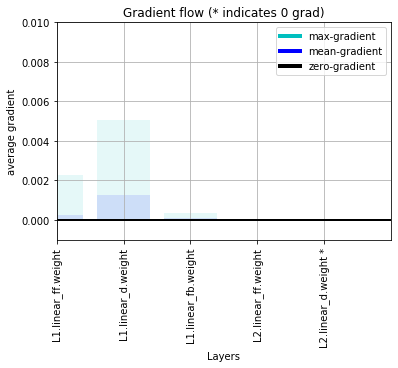

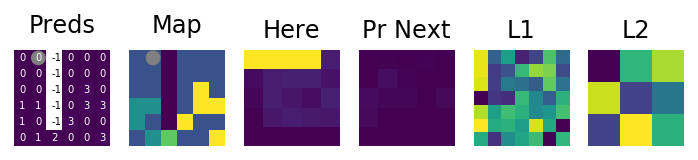

[tensor(0.0017), tensor(0.0038), tensor(0.0004), tensor(7.3545e-05), 0]
800/8000: Avg L1 fb weight: 0.15789, avg L2 ff weight: 0.07040, L1 max: 0.849, L2 max: 0.759, loss - 0.13722


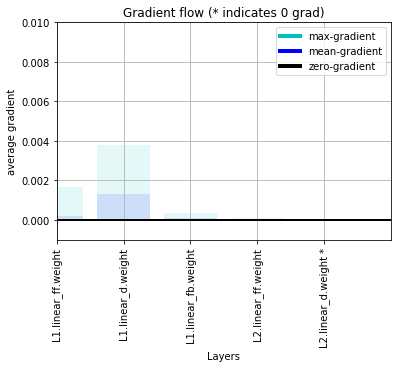

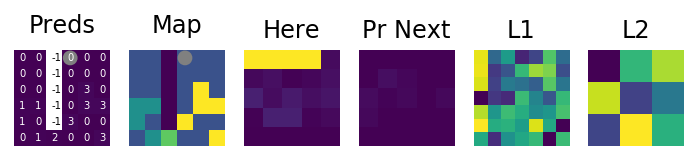

[tensor(0.0026), tensor(0.0074), tensor(0.0008), tensor(0.0001), 0]
1200/8000: Avg L1 fb weight: 0.15780, avg L2 ff weight: 0.07037, L1 max: 0.850, L2 max: 0.758, loss - 0.14224


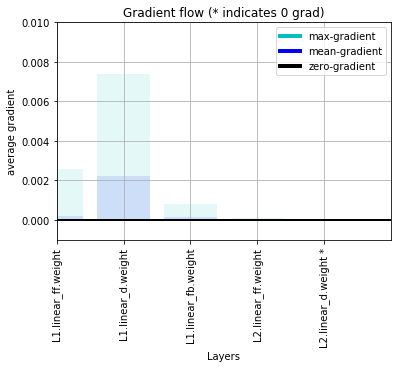

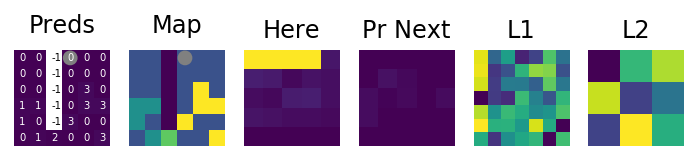

[tensor(0.0022), tensor(0.0040), tensor(0.0004), tensor(9.5483e-05), 0]
1600/8000: Avg L1 fb weight: 0.15769, avg L2 ff weight: 0.07034, L1 max: 0.849, L2 max: 0.758, loss - 0.15356


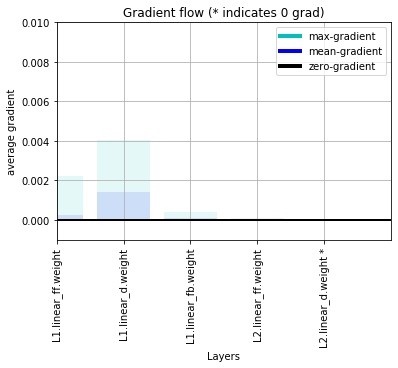

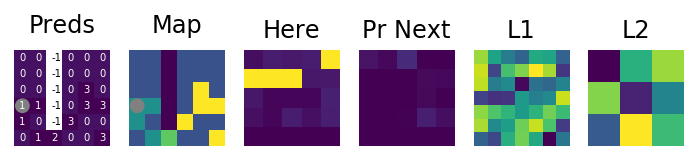

[tensor(0.0024), tensor(0.0039), tensor(0.0005), tensor(6.9148e-05), 0]
2000/8000: Avg L1 fb weight: 0.15757, avg L2 ff weight: 0.07031, L1 max: 0.850, L2 max: 0.757, loss - 0.17100


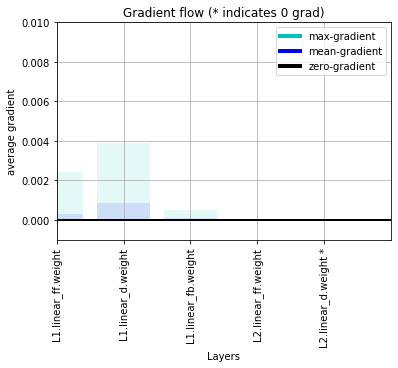

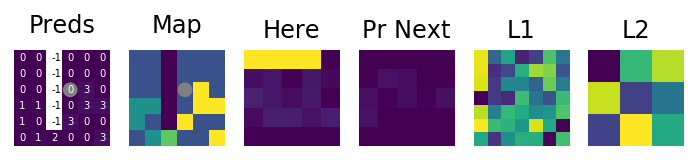

[tensor(0.0033), tensor(0.0072), tensor(0.0011), tensor(0.0002), 0]
2400/8000: Avg L1 fb weight: 0.15743, avg L2 ff weight: 0.07027, L1 max: 0.849, L2 max: 0.755, loss - 0.17053


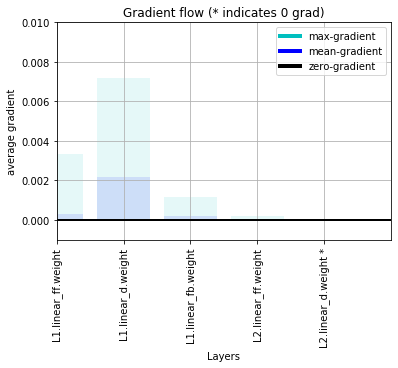

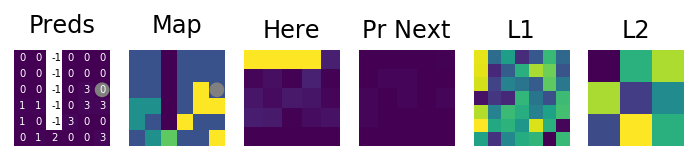

[tensor(0.0024), tensor(0.0031), tensor(0.0008), tensor(0.0001), 0]
2800/8000: Avg L1 fb weight: 0.15727, avg L2 ff weight: 0.07024, L1 max: 0.849, L2 max: 0.753, loss - 0.14229


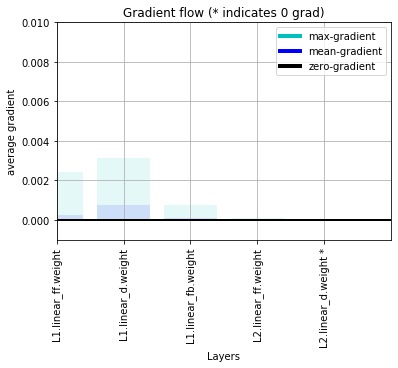

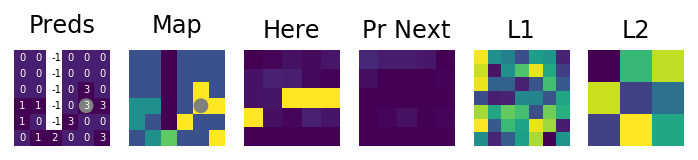

[tensor(0.0019), tensor(0.0045), tensor(0.0005), tensor(8.4096e-05), 0]
3200/8000: Avg L1 fb weight: 0.15712, avg L2 ff weight: 0.07020, L1 max: 0.849, L2 max: 0.751, loss - 0.14156


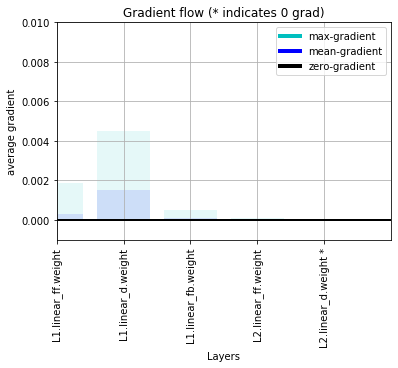

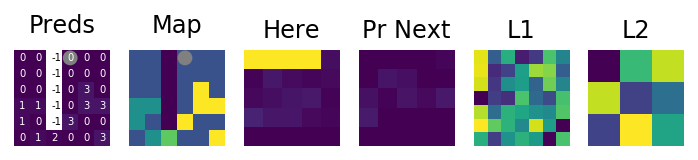

[tensor(0.0025), tensor(0.0032), tensor(0.0009), tensor(0.0001), 0]
3600/8000: Avg L1 fb weight: 0.15696, avg L2 ff weight: 0.07017, L1 max: 0.849, L2 max: 0.750, loss - 0.15358


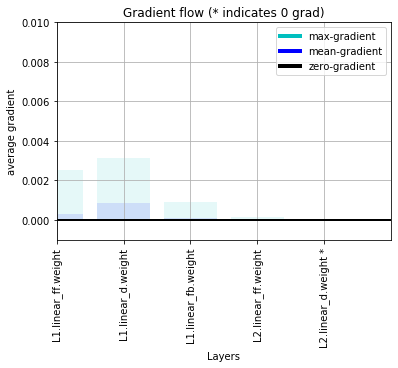

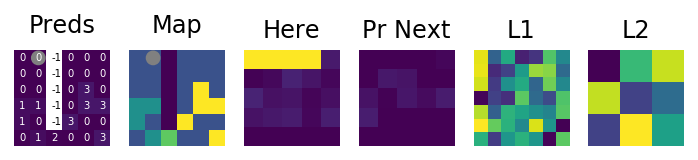

[tensor(0.0028), tensor(0.0067), tensor(0.0011), tensor(0.0002), 0]
4000/8000: Avg L1 fb weight: 0.15679, avg L2 ff weight: 0.07013, L1 max: 0.849, L2 max: 0.747, loss - 0.14256


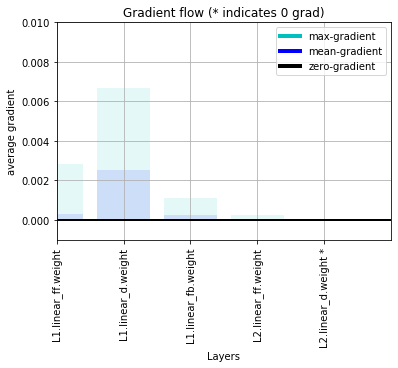

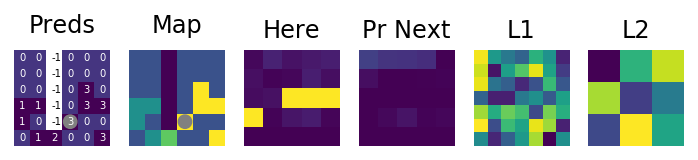

[tensor(0.0023), tensor(0.0033), tensor(0.0008), tensor(0.0002), 0]
4400/8000: Avg L1 fb weight: 0.15663, avg L2 ff weight: 0.07009, L1 max: 0.849, L2 max: 0.745, loss - 0.14473


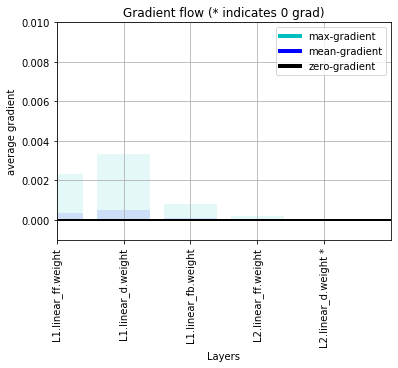

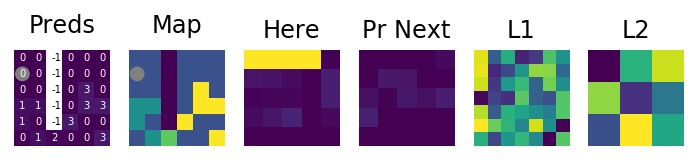

[tensor(0.0026), tensor(0.0081), tensor(0.0013), tensor(0.0002), 0]
4800/8000: Avg L1 fb weight: 0.15647, avg L2 ff weight: 0.07006, L1 max: 0.848, L2 max: 0.742, loss - 0.16189


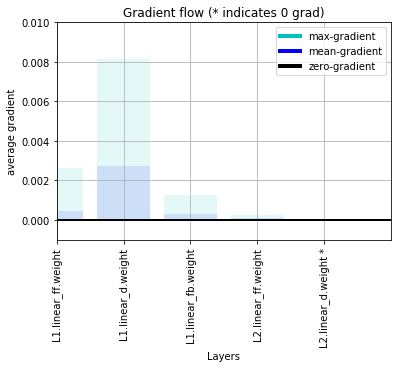

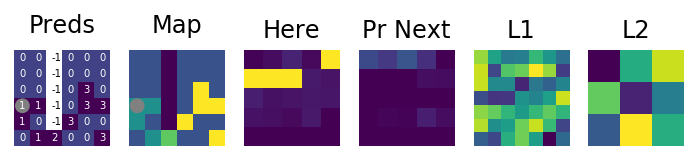

[tensor(0.0020), tensor(0.0049), tensor(0.0007), tensor(0.0001), 0]
5200/8000: Avg L1 fb weight: 0.15630, avg L2 ff weight: 0.07002, L1 max: 0.849, L2 max: 0.741, loss - 0.13327


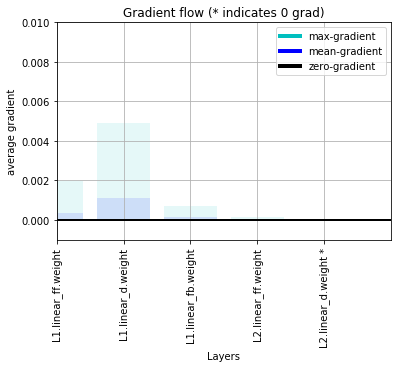

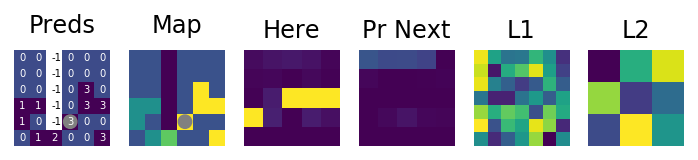

[tensor(0.0024), tensor(0.0061), tensor(0.0012), tensor(0.0002), 0]
5600/8000: Avg L1 fb weight: 0.15613, avg L2 ff weight: 0.06998, L1 max: 0.848, L2 max: 0.738, loss - 0.13755


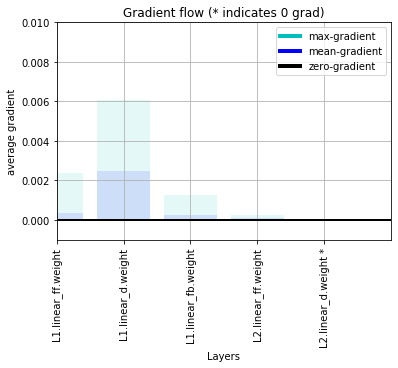

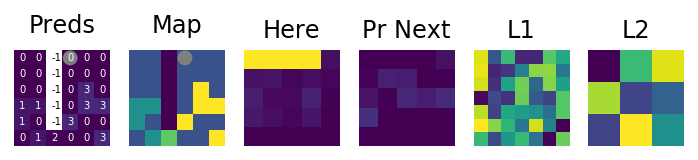

[tensor(0.0016), tensor(0.0052), tensor(0.0008), tensor(0.0001), 0]
6000/8000: Avg L1 fb weight: 0.15597, avg L2 ff weight: 0.06995, L1 max: 0.848, L2 max: 0.736, loss - 0.12971


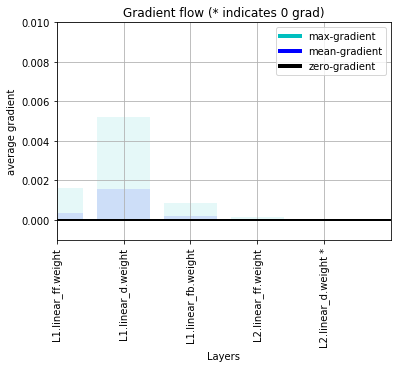

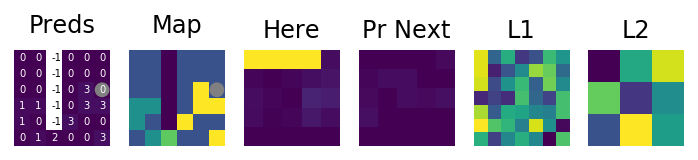

[tensor(0.0020), tensor(0.0040), tensor(0.0007), tensor(0.0002), 0]
6400/8000: Avg L1 fb weight: 0.15581, avg L2 ff weight: 0.06991, L1 max: 0.848, L2 max: 0.734, loss - 0.10815


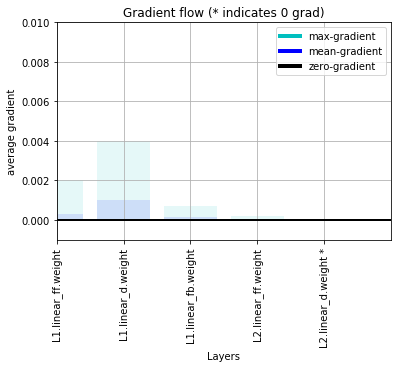

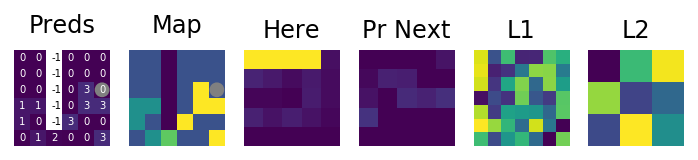

[tensor(0.0012), tensor(0.0060), tensor(0.0013), tensor(0.0002), 0]
6800/8000: Avg L1 fb weight: 0.15566, avg L2 ff weight: 0.06988, L1 max: 0.848, L2 max: 0.732, loss - 0.09253


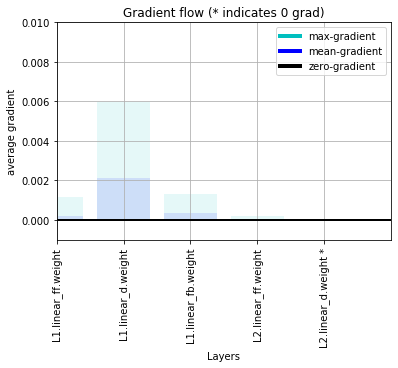

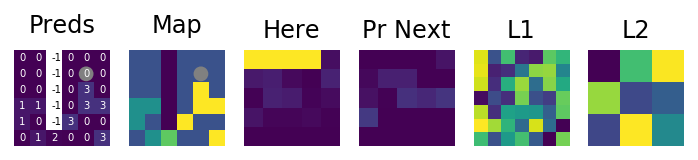

[tensor(0.0019), tensor(0.0076), tensor(0.0012), tensor(0.0003), 0]
7200/8000: Avg L1 fb weight: 0.15552, avg L2 ff weight: 0.06985, L1 max: 0.848, L2 max: 0.729, loss - 0.11335


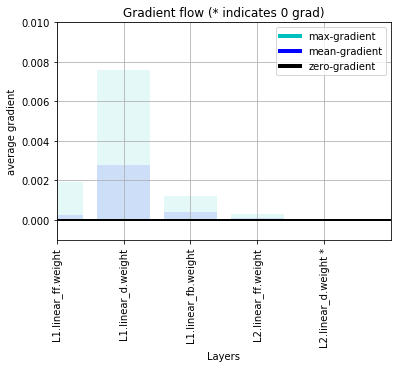

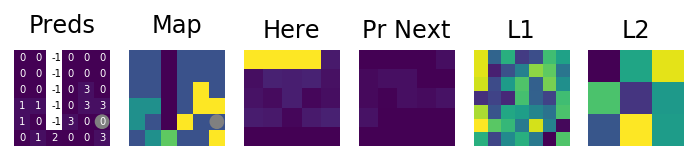

[tensor(0.0026), tensor(0.0062), tensor(0.0010), tensor(0.0003), 0]
7600/8000: Avg L1 fb weight: 0.15539, avg L2 ff weight: 0.06982, L1 max: 0.847, L2 max: 0.728, loss - 0.13638


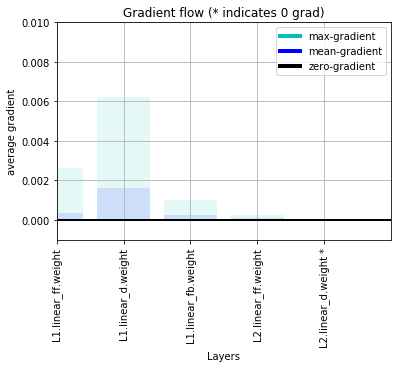

In [165]:
DEBUG = False
IT = True

env = Environment(landscape="partitioned_sm")
net = Net(d_in=env.n_digits * ENCODER_W, 
          bsz=100,  # number of agents
          cells=[7**2, 3**2],
          sparsity=0.5,
          bs=[1.0, 0.2],
          bidirectional=False,
          bidirectional_tied=False,
          input_transitions=IT,
          debug=DEBUG)
agent = Agents(net, env=env, lr=0.01, input_transitions=IT)

STEPS = 10 if DEBUG else 8000
TEST_STEPS = 0
PLOT_CLIFF = 0 # 600
PLOT_INTERVAL = 400
PLOT_LOSS = True
SAVE_ANIM = False
PLOT_GRADS = True

losses = []

video = None

# Training (agent roams free for a while)
for t in range(STEPS):
    x = agent.move()

    agent.net._retie_weights()

    loss, predictions = agent.step(x, learning=True, plot_state=DEBUG)
    losses.append(loss)
    
    if t and t >= PLOT_CLIFF and (t % PLOT_INTERVAL == 0 or SAVE_ANIM):
        fig = plot(predictions, agent, env, show=not SAVE_ANIM)
        if SAVE_ANIM:
            video = add_to_anim(video, fig, last=t == STEPS - 1)
        if PLOT_GRADS:
            plot_grad_flow(agent.net)
        avg_l1_fb = agent.net.L1.linear_fb.weight.abs().mean()
        avg_l2_ff = agent.net.L2.linear_ff.weight.abs().mean()        
        x_b = agent.last_hidden[0]
        l1max = x_b[0].max()
        l2max = x_b[1].max()
        print("%d/%d: Avg L1 fb weight: %.5f, avg L2 ff weight: %.5f, L1 max: %.3f, L2 max: %.3f, loss - %.5f" % (t, STEPS, avg_l1_fb, avg_l2_ff, l1max, l2max, loss))

if PLOT_LOSS:
    plt.plot(range(len(losses)), losses)
    plt.show()

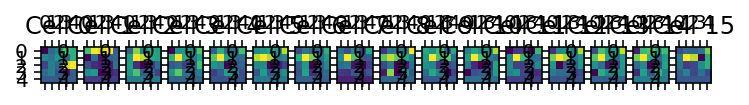

In [122]:
l2_cell_contributions(agent)

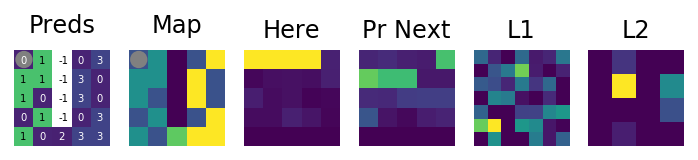

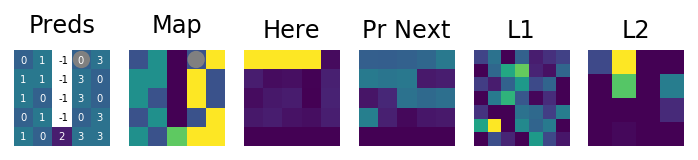

In [124]:
# Testing predictions from predetermined locations

for test_coord in [[0, 0], [0, 3]]:
    x = agent.move(to=torch.tensor(test_coord))
    loss, predictions = agent.step(x, learning=False)
    plot(predictions, agent, env, show=True)

### Analysis

Comparing learned FF and FB parameters post-training.

Semantics.

Spatial pooler (if allowed to), would develop similar representations of similar inputs? Useful for abstract predictions (via context), but not specific sequence orders. Relative importance of context vs sequence prediction depends on paradigm. In general, we'd like to perform both simultaneously, and be able to shift between a sequence-free prediction (context only), as well as detect subsequences within a given context when sequential stimuli are present.

Sensorimotor...

#### Degeneracy

It's possible to learn degenerate cases since we have a loop where feedback from L2(t-1) is input to L1(t), and L1(t-1) is input into L2(t-1). This loop is the very nature of the bidirectional connections taken as the premise... How to overcome it?

### Sequence prediction & lateral connections

### Relationship to grid cells & locations

Learning a spatial representation of context...

### Relationship to cortical columns

Similar, but inverse to canonincal column? Group of cells at L1 learn bidirectional connections with smaller group of cells in L2. Proximal connections taking feedback from above?

### Helper Functions

In [95]:
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import cv2

def plot(predictions, agent, env, show=False, batch_id=0):
    """
    Plot environment/agent state for one item in batch
    """
    fig, axs = plt.subplots(1, 6, dpi=144)
    mapped_predictions = torch.zeros_like(env.data).float()
    landscape = env.data.t()
    predictions = predictions.detach()
    thresh = 0.5
    eps = 0.2
    for i in range(env.h):
        for j in range(env.w):
            val = int(landscape[i, j].item())
            p = predictions[batch_id][val*ENCODER_W:(val+1)*ENCODER_W].mean()  # From encoded pred
            mapped_predictions[i, j] = p
            c = "white" if p < thresh else "black"
            axs[0].text(i-eps, j+eps, str(val), color=c, fontsize=5)
    agent_c = Circle((agent.location[batch_id, 1], agent.location[batch_id, 0]), 0.4, color="gray")
    axs[0].add_patch(agent_c)
    axs[0].matshow(mapped_predictions.t(), vmin=0, vmax=1)
    axs[0].set_title("Preds")

    agent_c_map = Circle((agent.location[batch_id, 1], agent.location[batch_id, 0]), 0.4, color="gray")
    axs[1].matshow(landscape.t())
    axs[1].set_title("Map")
    axs[1].add_patch(agent_c_map)
    
    x = env.sense(agent.location)[batch_id]
    axs[2].imshow(activity_square(x), vmin=0, vmax=1)
    axs[2].set_title("Here")    
    axs[3].imshow(activity_square(predictions[batch_id]), vmin=0, vmax=1)
    axs[3].set_title("Pr Next")
    
    hidden = agent.last_hidden
    x_bs, = hidden
    axs[4].imshow(activity_square(x_bs[0][batch_id].detach()))
    axs[4].set_title("L1")

    axs[5].imshow(activity_square(x_bs[1][batch_id].detach()))
    axs[5].set_title("L2")    
    for ax in axs:
        ax.axis("off")    
    if show:
        plt.show()
    return fig

def square_size(n):
    side = int(np.sqrt(n))
    if side ** 2 < n:
        side += 1
    return side

def activity_square(vector):
    n = len(vector)
    side = square_size(n)
    square = torch.zeros(side ** 2)
    square[:n] = vector
    return square.view(side, side)

def debug_log(tensor_dict, truncate_len=400):
    for name, t in tensor_dict.items():
        if isinstance(t, torch.Tensor):
            t = t.detach().squeeze()
            if t.dim() == 1:
                t = t.flatten()
                size = t.numel()
                plt.imshow(activity_square(t))
                tmin = t.min()
                tmax = t.max()
                tsum = t.sum()
                plt.title(
                    "%s (%s, rng: %.3f-%.3f, sum: %.3f)"
                    % (name, size, tmin, tmax, tsum)
                )
                plt.show()

def _repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(_repackage_hidden(v) for v in h)

def plot_grad_flow(model, top=0.01):
    """
    Plots the gradients flowing through different layers in the net during
    training. Can be used for checking for possible gradient
    vanishing / exploding problems.

    Usage: Plug this function in Trainer class after loss.backwards() as
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow
    """
    ave_grads = []
    max_grads = []
    layers = []
    for n, p in model.named_parameters():
        if (p.requires_grad) and ("bias" not in n):
            zg = False
            if p.grad is not None:
                pmax = p.grad.abs().max()
                ave_grads.append(p.grad.abs().mean())
                max_grads.append(pmax)
                zg = pmax == 0
            else:
                ave_grads.append(0)
                max_grads.append(0)
                zg = True
            if zg:
                n += " *"
            layers.append(n)
    print(max_grads)
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads) + 1, lw=2, color="k")
    plt.xticks(range(0, len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom=-0.001, top=top)  # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow (* indicates 0 grad)")
    plt.grid(True)
    LABELS = ["max-gradient", "mean-gradient", "zero-gradient"]
    plt.legend(
        [
            Line2D([0], [0], color="c", lw=4),
            Line2D([0], [0], color="b", lw=4),
            Line2D([0], [0], color="k", lw=4),
        ],
        LABELS
    )

def fig2img(fig):
    canvas = FigureCanvas(fig)
    canvas.draw()

    width, height = fig.get_size_inches() * fig.get_dpi()
    img = np.fromstring(canvas.tostring_rgb(), dtype="uint8").reshape(
        int(height), int(width), 3
    )
    return img

def add_to_anim(video, fig, image_folder='./snapshots', video_name='stiched.avi', last=False):
    frame = fig2img(fig)
    
    if video is None:
        height, width, layers = frame.shape
        fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
        video = cv2.VideoWriter(video_name, fourcc, 5.0, (width,height))

    video.write(frame)

    if last:
        print("Saving %s" % video_name)
        cv2.destroyAllWindows()
        video.release() 
    return video

def l2_cell_contributions(agent):
    net = agent.net
    x_b_2 = agent.last_hidden[0][1][0].detach()
    n_cells = len(x_b_2)
    fig, axs = plt.subplots(1, n_cells, dpi=144)
    for i in range(n_cells):
        l2_art = torch.zeros_like(x_b_2).float()
        l2_art[i] = 1
        axs[i].matshow(activity_square(net.L1.decode(net.L1.linear_fb(l2_art)).detach()))
        axs[i].set_title("Cell %d" % i)
    plt.show()
        
def plot_net_state(net, last_pred, input, hidden):
    tensor_labels = ['z_a', 'z_a g', 'z_fb', 'z_fb g', 'sigma']
    n_layers = 2
    plot_w = len(tensor_labels) + 1
    fig, axs = plt.subplots(n_layers, plot_w, dpi=144, figsize=(8, 3))
    axs[0, plot_w-1].matshow(activity_square(input.squeeze()))    
    axs[0, plot_w-1].set_title("Inp")    
    axs[1, plot_w-1].matshow(activity_square(last_pred.detach().squeeze()))
    axs[1, plot_w-1].set_title("Pred")
    axs[0, plot_w-1].axis("off")
    axs[1, plot_w-1].axis("off")
    for l, layer in enumerate(net.children()):
        tvalues = [layer.z_a, layer.z_a.grad, layer.z_fb, layer.z_fb.grad, layer.sigma]
        for i, t in enumerate(tvalues):
            ax = axs[1-l][i]
            ax.axis("off")
            if t is None:
                ax.set_visible(False)
            else:
                label = tensor_labels[i]
                is_grad = " g" in label
                cmap = "plasma" if is_grad else "viridis"
                ax.matshow(activity_square(t.detach().squeeze()), cmap=cmap)
                ax.set_title("L%d %s" % (l+1, label))
    plt.show()
        
    